<h3> Simple graph classification task</h3>

In this tutorial, you learn how to perform batched graph classification
with DGL. The example task objective is to classify eight types of topologies shown here.

![title](graph_classifier_1.png)

Implement a synthetic dataset :class:`data.MiniGCDataset` in DGL. The dataset has eight  different types of graphs and each class has the same number of graph samples.

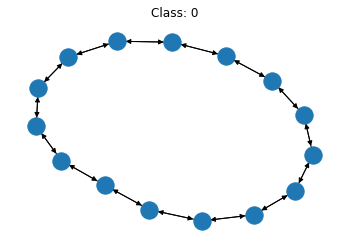

In [22]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
# A dataset with 80 samples, each graph is
# of size [10, 20]
dataset = MiniGCDataset(80, 10, 20)
graph, label = dataset[0]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

In [2]:
graph.num_nodes()

15

In [3]:
graph.num_edges()

45

In [4]:
graph.in_degrees()

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [5]:
graph.out_degrees()

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

 Form a graph mini-batch

 To train neural networks efficiently, a common practice is to batch
 multiple samples together to form a mini-batch. Batching fixed-shaped tensor
 inputs is common. For example, batching two images of size 28 x 28
 gives a tensor of shape 2 x 28 x 28. By contrast, batching graph inputs
 has two challenges:

 * Graphs are sparse.
 * Graphs can have various length. For example, number of nodes and edges.

 To address this, DGL provides a :func:`dgl.batch` API. It leverages the idea that  a batch of graphs can be viewed as a large graph that has many disjointed connected components. Below is a visualization that gives the general idea.

 .. image:: https://data.dgl.ai/tutorial/batch/batch.png
     :width: 400pt
     :align: center

 Define the following ``collate`` function to form a mini-batch from a given list of graph and label pairs.


In [6]:
import dgl
import torch

def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

# The return type of :func:`dgl.batch` is still a graph. In the same way, 
# a batch of tensors is still a tensor. This means that any code that works
# for one graph immediately works for a batch of graphs. More importantly,
# because DGL processes messages on all nodes and edges in parallel, this greatly
# improves efficiency.

<h3> Graph Classifier </h3>

![Here is](graph_classifier_2.png)

 From a batch of graphs, perform message passing and graph convolution
 for nodes to communicate with others. After message passing, compute a
 tensor for graph representation from node (and edge) attributes. This    step might be called readout or aggregation. Finally, the graph 
 representations are fed into a classifier :math:`g` to predict the graph labels.

 Graph convolution layer can be found in the ``dgl.nn.<backend>`` submodule.

In [7]:
from dgl.nn.pytorch import GraphConv

Readout and classification

For this demonstration, consider initial node features to be their degrees. After two rounds of graph convolution, perform a graph readout by averaging over all node features for each graph in the batch.

$  h_g=\frac{1}{|\mathcal{V}|}\sum_{v\in\mathcal{V}}h_{v}$

 In DGL, :func:`dgl.mean_nodes` handles this task for a batch of
 classifier with one linear layer to obtain pre-softmax logits.


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        h = g.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')     ### Readout Function
        return self.classify(hg)

<h4> Setup and training</h4>

 Create a synthetic dataset of :math:`400` graphs with :math:`10` ~
 :math:`20` nodes. :math:`320` graphs constitute a training set and
 :math:`80` graphs constitute a test set.


In [140]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Create training and test sets.
trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=32, shuffle=True,
                         collate_fn=collate)


In [49]:
dir(trainset)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_download',
 '_force_reload',
 '_gen_circular_ladder',
 '_gen_clique',
 '_gen_cycle',
 '_gen_grid',
 '_gen_hypercube',
 '_gen_lollipop',
 '_gen_star',
 '_gen_wheel',
 '_generate',
 '_get_hash',
 '_hash',
 '_hash_func',
 '_hash_key',
 '_load',
 '_name',
 '_raw_dir',
 '_save_dir',
 '_url',
 '_verbose',
 'download',
 'graphs',
 'has_cache',
 'hash',
 'labels',
 'load',
 'max_num_v',
 'min_num_v',
 'name',
 'num_classes',
 'num_graphs',
 'process',
 'raw_dir',
 'raw_path',
 'save',
 'save_dir',
 'save_graph',
 'save_path',
 'seed',
 'url',
 'verbose']

In [141]:
trainset.labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,

In [55]:
trainset.graphs[0]

Graph(num_nodes=15, num_edges=45,
      ndata_schemes={}
      edata_schemes={})

In [48]:
for iter, (bg, label) in enumerate(data_loader):
    print(bg)

Graph(num_nodes=449, num_edges=3231,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=426, num_edges=2960,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=463, num_edges=2153,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=429, num_edges=2519,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=481, num_edges=2911,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=456, num_edges=2760,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=417, num_edges=2427,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=438, num_edges=3030,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=444, num_edges=2212,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=431, num_edges=2193,
      ndata_schemes={}
      edata_schemes={})


In [10]:
# Create model
model = Classifier(1, 256, trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

Classifier(
  (conv1): GraphConv(in=1, out=256, normalization=both, activation=None)
  (conv2): GraphConv(in=256, out=256, normalization=both, activation=None)
  (classify): Linear(in_features=256, out_features=8, bias=True)
)

In [11]:
epoch_losses = []
for epoch in range(80):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 0, loss 1.9815
Epoch 1, loss 1.9723
Epoch 2, loss 1.9607
Epoch 3, loss 1.9500
Epoch 4, loss 1.9330
Epoch 5, loss 1.9174
Epoch 6, loss 1.9019
Epoch 7, loss 1.8827
Epoch 8, loss 1.8567
Epoch 9, loss 1.8245
Epoch 10, loss 1.7827
Epoch 11, loss 1.7350
Epoch 12, loss 1.6863
Epoch 13, loss 1.6428
Epoch 14, loss 1.5866
Epoch 15, loss 1.5263
Epoch 16, loss 1.4728
Epoch 17, loss 1.4007
Epoch 18, loss 1.3406
Epoch 19, loss 1.2909
Epoch 20, loss 1.2373
Epoch 21, loss 1.1906
Epoch 22, loss 1.1461
Epoch 23, loss 1.1022
Epoch 24, loss 1.0747
Epoch 25, loss 1.0517
Epoch 26, loss 1.0203
Epoch 27, loss 1.0043
Epoch 28, loss 0.9728
Epoch 29, loss 0.9418
Epoch 30, loss 0.9254
Epoch 31, loss 0.9029
Epoch 32, loss 0.8914
Epoch 33, loss 0.8793
Epoch 34, loss 0.8733
Epoch 35, loss 0.8575
Epoch 36, loss 0.8404
Epoch 37, loss 0.8413
Epoch 38, loss 0.8339
Epoch 39, loss 0.8265
Epoch 40, loss 0.8293
Epoch 41, loss 0.8041
Epoch 42, loss 0.8111
Epoch 43, loss 0.7913
Epoch 44, loss 0.8166
Epoch 45, loss 0.797

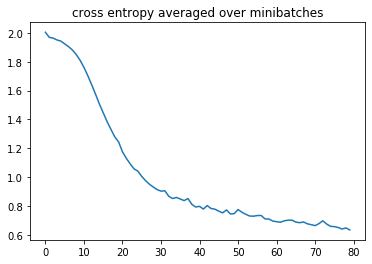

In [25]:
# The learning curve of a run is presented below.

plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

In [37]:
# The trained model is evaluated on the test set created. To deploy
# the tutorial, restrict the running time to get a higher
# accuracy (:math:`80` % ~ :math:`90` %) than the ones printed below.

model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

Accuracy of sampled predictions on the test set: 61.2500%
Accuracy of argmax predictions on the test set: 65.000000%


Softmax turn logits (numeric output of the last linear layer of a multi-class classification neural network) into probabilities by take the exponents of each output and then normalize each number by the sum of those exponents so the entire output vector adds up to one — all probabilities should add up to one. Cross entropy loss is usually the loss function for such a multi-class classification problem. Softmax is frequently appended to the last layer of an image classification network 

Indices are ordered from left to right according to when each was sampled.
torch.multinomial -> Returns a tensor where each row contains num_samples indices sampled from the multinomial probability distribution located in the corresponding row of tensor input

In [29]:
test_bg = dgl.batch(test_X)

In [32]:
test_X

[Graph(num_nodes=15, num_edges=45,
       ndata_schemes={}
       edata_schemes={}), Graph(num_nodes=10, num_edges=30,
       ndata_schemes={}
       edata_schemes={}), Graph(num_nodes=13, num_edges=39,
       ndata_schemes={}
       edata_schemes={}), Graph(num_nodes=13, num_edges=39,
       ndata_schemes={}
       edata_schemes={}), Graph(num_nodes=17, num_edges=51,
       ndata_schemes={}
       edata_schemes={}), Graph(num_nodes=19, num_edges=57,
       ndata_schemes={}
       edata_schemes={}), Graph(num_nodes=13, num_edges=39,
       ndata_schemes={}
       edata_schemes={}), Graph(num_nodes=15, num_edges=45,
       ndata_schemes={}
       edata_schemes={}), Graph(num_nodes=12, num_edges=36,
       ndata_schemes={}
       edata_schemes={}), Graph(num_nodes=14, num_edges=42,
       ndata_schemes={}
       edata_schemes={}), Graph(num_nodes=17, num_edges=49,
       ndata_schemes={}
       edata_schemes={}), Graph(num_nodes=16, num_edges=46,
       ndata_schemes={}
       edata_sche

In [34]:
model(test_bg)

tensor([[ 1.4051e+01,  3.3241e+00, -8.9414e+00, -3.2399e+00,  1.8490e+00,
          1.0465e+01, -2.6754e+01,  4.5853e+00],
        [ 1.4051e+01,  3.3241e+00, -8.9414e+00, -3.2399e+00,  1.8490e+00,
          1.0465e+01, -2.6754e+01,  4.5853e+00],
        [ 1.4051e+01,  3.3241e+00, -8.9414e+00, -3.2399e+00,  1.8490e+00,
          1.0465e+01, -2.6754e+01,  4.5853e+00],
        [ 1.4051e+01,  3.3241e+00, -8.9414e+00, -3.2399e+00,  1.8490e+00,
          1.0465e+01, -2.6754e+01,  4.5853e+00],
        [ 1.4051e+01,  3.3241e+00, -8.9414e+00, -3.2399e+00,  1.8490e+00,
          1.0465e+01, -2.6754e+01,  4.5853e+00],
        [ 1.4051e+01,  3.3241e+00, -8.9414e+00, -3.2399e+00,  1.8490e+00,
          1.0465e+01, -2.6754e+01,  4.5853e+00],
        [ 1.4051e+01,  3.3241e+00, -8.9414e+00, -3.2399e+00,  1.8490e+00,
          1.0465e+01, -2.6754e+01,  4.5853e+00],
        [ 1.4051e+01,  3.3241e+00, -8.9414e+00, -3.2399e+00,  1.8490e+00,
          1.0465e+01, -2.6754e+01,  4.5853e+00],
        [ 1.4051

In [35]:
probs_Y = torch.softmax(model(test_bg), 1)

In [36]:
probs_Y

tensor([[9.7294e-01, 2.1345e-05, 1.0057e-10, 3.0103e-08, 4.8832e-06, 2.6955e-02,
         1.8465e-18, 7.5340e-05],
        [9.7294e-01, 2.1345e-05, 1.0057e-10, 3.0103e-08, 4.8832e-06, 2.6955e-02,
         1.8465e-18, 7.5340e-05],
        [9.7294e-01, 2.1345e-05, 1.0057e-10, 3.0103e-08, 4.8832e-06, 2.6955e-02,
         1.8465e-18, 7.5340e-05],
        [9.7294e-01, 2.1345e-05, 1.0057e-10, 3.0103e-08, 4.8832e-06, 2.6955e-02,
         1.8465e-18, 7.5340e-05],
        [9.7294e-01, 2.1345e-05, 1.0057e-10, 3.0103e-08, 4.8832e-06, 2.6955e-02,
         1.8465e-18, 7.5340e-05],
        [9.7294e-01, 2.1345e-05, 1.0057e-10, 3.0103e-08, 4.8832e-06, 2.6955e-02,
         1.8465e-18, 7.5340e-05],
        [9.7294e-01, 2.1345e-05, 1.0057e-10, 3.0103e-08, 4.8832e-06, 2.6955e-02,
         1.8465e-18, 7.5340e-05],
        [9.7294e-01, 2.1345e-05, 1.0057e-10, 3.0103e-08, 4.8832e-06, 2.6955e-02,
         1.8465e-18, 7.5340e-05],
        [9.7294e-01, 2.1345e-05, 1.0057e-10, 3.0103e-08, 4.8832e-06, 2.6955e-02,

In [142]:
sampled_Y

NameError: name 'sampled_Y' is not defined

In [45]:
dir(model.forward)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [14]:
dir(model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_forward_unimplemented',
 '_get_name',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_dict_hooks',
 '_version',
 'add_module',
 'apply',
 'bfloat16',
 'buffers',
 'children',
 'classify',
 'conv1',
 '

In [18]:
model.conv1(bg, torch.tensor(3))

RuntimeError: size mismatch, m1: [1 x 451], m2: [1 x 256] at ..\aten\src\TH/generic/THTensorMath.cpp:41

In [14]:
prediction = model(bg)

In [15]:
prediction.shape

torch.Size([32, 8])

In [143]:
trainset.labels[0]

tensor(0, dtype=torch.int32)

In [144]:
First_layer_pred = []
for i in range(0,len(trainset)):
    h = trainset.graphs[i].in_degrees().view(-1, 1).float()
    x = F.relu(model.conv1(trainset.graphs[i], h))
    First_layer_pred.append(np.mean(x.detach().numpy(),0))

In [145]:
First_layer_pred[0]

array([0.        , 0.00635034, 0.46580884, 0.        , 0.        ,
       0.        , 0.        , 0.906904  , 0.663962  , 0.6638413 ,
       0.        , 0.        , 0.20090936, 0.        , 0.4599849 ,
       0.        , 0.65087616, 0.23567295, 0.        , 0.        ,
       0.62305766, 0.        , 0.00573289, 0.        , 0.50708526,
       0.        , 0.        , 0.        , 0.21028902, 0.47279823,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.8486909 , 0.        , 0.        , 0.        ,
       0.655961  , 0.00484467, 0.04229152, 0.9618952 , 0.        ,
       0.01206209, 0.06131314, 0.13936044, 0.        , 0.        ,
       0.64867246, 0.0068385 , 0.        , 0.        , 0.01709291,
       0.6725359 , 0.01213597, 0.006284  , 0.05669726, 0.00584662,
       0.        , 0.3655272 , 0.0080488 , 0.00589496, 0.6497811 ,
       0.65544856, 0.        , 0.96731466, 0.        , 0.        ,
       0.09132253, 0.1177019 , 0.71560794, 0.        , 0.00574

In [146]:
First_layer_pred = np.stack(First_layer_pred, axis=0)

In [147]:
type(First_layer_pred)

numpy.ndarray

In [148]:
from sklearn.manifold import TSNE

In [149]:
First_layer_TSNE = TSNE(2, perplexity = 10, learning_rate=10, verbose=1, n_iter=2000, random_state=2020)
Y = First_layer_TSNE.fit_transform(First_layer_pred)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 320 samples in 0.012s...
[t-SNE] Computed neighbors for 320 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 320 / 320
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.541618
[t-SNE] KL divergence after 2000 iterations: -0.483263


In [150]:
Y

array([[-1.11080189e+01, -1.45068939e+02],
       [ 7.60516815e+01, -4.67540169e+01],
       [ 1.28123001e+02, -4.94698753e+01],
       [ 1.28373520e+02, -4.30528488e+01],
       [-7.09187698e+00, -1.50395432e+02],
       [ 2.21032357e+00, -1.88908173e+02],
       [ 1.34548325e+02, -4.86320992e+01],
       [-1.51577854e+00, -1.44488739e+02],
       [ 9.72004242e+01, -4.30342941e+01],
       [ 1.24148651e+02, -5.45623245e+01],
       [ 1.62315285e+00, -1.58110352e+02],
       [-6.06417322e+00, -1.57699097e+02],
       [-1.37178984e+01, -1.89851974e+02],
       [-1.13007536e+01, -1.83867340e+02],
       [ 8.61759262e+01, -4.49271622e+01],
       [-6.06417322e+00, -1.57699097e+02],
       [-1.40646827e+00, -1.52289917e+02],
       [-1.26485710e+01, -1.53749344e+02],
       [-7.37272596e+00, -1.89799118e+02],
       [ 8.61759262e+01, -4.49271622e+01],
       [-1.51577854e+00, -1.44488739e+02],
       [ 2.21032357e+00, -1.88908173e+02],
       [-5.16485023e+00, -1.83362244e+02],
       [-1.

In [75]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [118]:
colors = cm.rainbow(np.linspace(0, 1, max(trainset.labels).detach().numpy()+1)) 

In [168]:
colors

array([[5.00000000e-01, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [2.17647059e-01, 4.29120609e-01, 9.75511968e-01, 1.00000000e+00],
       [7.25490196e-02, 7.82927610e-01, 9.00586702e-01, 1.00000000e+00],
       [3.54901961e-01, 9.74138602e-01, 7.82927610e-01, 1.00000000e+00],
       [6.45098039e-01, 9.74138602e-01, 6.22112817e-01, 1.00000000e+00],
       [9.27450980e-01, 7.82927610e-01, 4.34676422e-01, 1.00000000e+00],
       [1.00000000e+00, 4.29120609e-01, 2.19946358e-01, 1.00000000e+00],
       [1.00000000e+00, 1.22464680e-16, 6.12323400e-17, 1.00000000e+00]])

In [155]:
max(trainset.labels).detach().numpy()

array(7)

In [157]:
trainset_label_array = trainset.labels.detach().numpy()

In [158]:
label_index = (trainset_label_array == 0)

In [180]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()
for i in range(0,max(trainset.labels).detach().numpy()+1):
    label_index = (trainset_label_array == i)
    #color_indx = int(trainset.labels[i].detach().numpy());
    ax.scatter(Y[label_index, 0], Y[label_index, 1],color=colors[i])
#handles, labels = ax.get_legend_handles_labels()
plt.legend(['cycle_graph','star_graph','wheel_graph','lollipop_graph','hypercube_graph','grid_graph','complete_graph','circular_ladder_graph'], loc='best')
plt.title('TSNE of First Layer Output')
plt.show()

In [164]:
label_index

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [165]:
Y[label_index, 0]

array([149.16658 , 139.45096 ,  53.504948, 140.988   , 127.51595 ,
       149.03987 , 156.03798 , 149.03987 ,  78.09788 , 128.55754 ,
        60.08878 , 134.39641 , 102.677536, 149.16658 ,  74.93272 ,
        60.08878 , 149.16658 ,  78.09788 , 139.6376  , 140.988   ,
       102.677536, 102.677536,  60.08878 , 145.43332 , 140.79567 ,
       141.90448 , 102.677536,  59.04462 , 101.11891 , 141.84409 ,
       133.23534 ,  60.08878 ,  78.09788 , 107.9819  , 127.23521 ,
        78.09788 , 135.14864 , 133.74823 , 146.05042 , 149.16658 ],
      dtype=float32)

In [175]:
Second_layer_pred = []
for i in range(0,len(trainset)):
    h = trainset.graphs[i].in_degrees().view(-1, 1).float()
    h = F.relu(model.conv1(trainset.graphs[i], h))
    x = F.relu(model.conv2(trainset.graphs[i], h))
    Second_layer_pred.append(np.mean(x.detach().numpy(),0))

In [176]:
Second_layer_pred = np.stack(Second_layer_pred, axis=0)

In [193]:
Second_layer_TSNE = TSNE(2, perplexity = 10, learning_rate=10, verbose=1, n_iter=2000, random_state=2020)
Y = Second_layer_TSNE.fit_transform(Second_layer_pred)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 320 samples in 0.012s...
[t-SNE] Computed neighbors for 320 samples in 0.027s...
[t-SNE] Computed conditional probabilities for sample 320 / 320
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.299900
[t-SNE] KL divergence after 2000 iterations: -0.449301


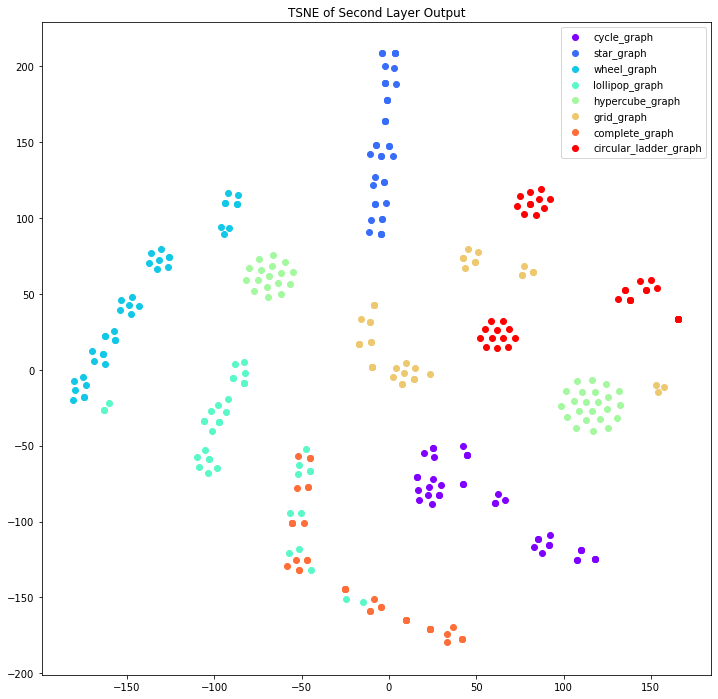

In [194]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()
for i in range(0,max(trainset.labels).detach().numpy()+1):
    label_index = (trainset_label_array == i)
    #color_indx = int(trainset.labels[i].detach().numpy());
    ax.scatter(Y[label_index, 0], Y[label_index, 1],color=colors[i])
#handles, labels = ax.get_legend_handles_labels()
plt.legend(['cycle_graph','star_graph','wheel_graph','lollipop_graph','hypercube_graph','grid_graph','complete_graph','circular_ladder_graph'], loc='best')
plt.title('TSNE of Second Layer Output')
plt.show()

In [191]:
Classify_layer_pred = []
for i in range(0,len(trainset)):
    x = model(trainset.graphs[i])
    Classify_layer_pred.append(np.mean(x.detach().numpy(),0))

In [192]:
Classify_layer_pred = np.stack(Classify_layer_pred, axis=0)

In [195]:
Classify_layer_TSNE = TSNE(2, perplexity = 10, learning_rate=10, verbose=1, n_iter=2000, random_state=2020)
Y = Classify_layer_TSNE.fit_transform(Classify_layer_pred)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 320 samples in 0.001s...
[t-SNE] Computed neighbors for 320 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 320 / 320
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.660587
[t-SNE] KL divergence after 2000 iterations: -0.407421


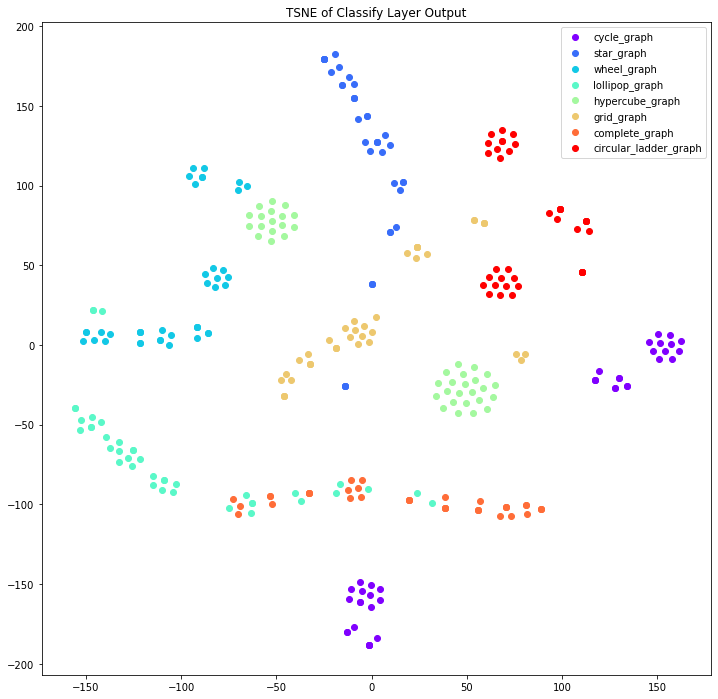

In [196]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()
for i in range(0,max(trainset.labels).detach().numpy()+1):
    label_index = (trainset_label_array == i)
    #color_indx = int(trainset.labels[i].detach().numpy());
    ax.scatter(Y[label_index, 0], Y[label_index, 1],color=colors[i])
#handles, labels = ax.get_legend_handles_labels()
plt.legend(['cycle_graph','star_graph','wheel_graph','lollipop_graph','hypercube_graph','grid_graph','complete_graph','circular_ladder_graph'], loc='best')
plt.title('TSNE of Classify Layer Output')
plt.show()

In [16]:
h = trainset.graphs[235].in_degrees().view(-1, 1).float()

In [17]:
h.shape

torch.Size([10, 1])

In [18]:
x = F.relu(model.conv1(trainset.graphs[235], h))

In [19]:
x.shape

torch.Size([10, 256])

In [30]:
x

tensor([[0.0000, 0.0207, 0.4733,  ..., 0.4410, 0.0221, 0.0432],
        [0.0000, 0.0207, 0.4733,  ..., 0.4410, 0.0221, 0.0432],
        [0.0000, 0.0867, 0.5076,  ..., 0.5583, 0.0930, 0.1183],
        ...,
        [0.0000, 0.0867, 0.5076,  ..., 0.5583, 0.0930, 0.1183],
        [0.0000, 0.0207, 0.4733,  ..., 0.4410, 0.0221, 0.0432],
        [0.0000, 0.0207, 0.4733,  ..., 0.4410, 0.0221, 0.0432]],
       grad_fn=<ReluBackward0>)

In [32]:
np.mean(x.detach().numpy(),0)

array([0.        , 0.06282251, 0.49513087, 0.        , 0.        ,
       0.        , 0.        , 1.0150828 , 0.720852  , 0.8016842 ,
       0.        , 0.        , 0.26686653, 0.        , 0.47322187,
       0.        , 0.70951504, 0.32819238, 0.        , 0.        ,
       0.7527854 , 0.        , 0.06541852, 0.        , 0.53135145,
       0.        , 0.        , 0.        , 0.29378667, 0.6008326 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.94386685, 0.        , 0.        , 0.        ,
       0.74052286, 0.0621765 , 0.11175314, 1.0870229 , 0.        ,
       0.06167049, 0.12201588, 0.22321728, 0.        , 0.        ,
       0.7086924 , 0.06141835, 0.        , 0.        , 0.08010171,
       0.73347795, 0.0596354 , 0.06561718, 0.10714191, 0.06289883,
       0.        , 0.47556558, 0.0691704 , 0.0688483 , 0.73222256,
       0.7353724 , 0.        , 1.0991019 , 0.        , 0.        ,
       0.1701107 , 0.19400367, 0.80919045, 0.        , 0.06278

In [104]:
xtemp.to_csv('convLayerOutput_Graph5.csv')

In [96]:
trainset.graphs[235].in_degrees()

tensor([3, 3, 4, 4, 4, 4, 4, 4, 3, 3])